In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config Completer.use_jedi = False  # to make autocompletion faster

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
tf.__version__

In [3]:

# load kaggle environment if in google colab
from google.colab import files
files.upload() #upload kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!mkdir logs


Saving kaggle.json to kaggle.json
kaggle.json


In [4]:

!kaggle competitions download -c web-traffic-time-series-forecasting
!yes|unzip web-traffic-time-series-forecasting.zip
!yes|unzip train_2.csv.zip
!tail -n +2 train_2.csv|shuf --random-source train_2.csv > train_2_shuffled.csv
!head -n -10000 train_2_shuffled.csv > train_set.csv
!tail -n 10000 train_2_shuffled.csv > validation_set.csv


 81% 82.0M/101M [00:02<00:00, 20.4MB/s]
100% 101M/101M [00:02<00:00, 48.7MB/s] 
 92% 63.0M/68.2M [00:00<00:00, 47.0MB/s]
100% 68.2M/68.2M [00:00<00:00, 76.7MB/s]
 96% 92.0M/96.0M [00:01<00:00, 52.9MB/s]
100% 96.0M/96.0M [00:01<00:00, 76.4MB/s]
 88% 90.0M/102M [00:00<00:00, 71.2MB/s]
100% 102M/102M [00:01<00:00, 106MB/s]  
 89% 59.0M/66.0M [00:01<00:00, 39.8MB/s]
100% 66.0M/66.0M [00:01<00:00, 56.9MB/s]
 90% 135M/150M [00:03<00:00, 27.8MB/s]
100% 150M/150M [00:03<00:00, 48.1MB/s]
unzip:  cannot find or open web-traffic-time-series-forecasting.zip, web-traffic-time-series-forecasting.zip.zip or web-traffic-time-series-forecasting.zip.ZIP.
Archive:  train_2.csv.zip
  inflating: train_2.csv             


## Make dataset

In [5]:
output_len = 62
normalize_ds = True
def process_line(line):
    line = tf.io.decode_csv(line, record_defaults=[""]+[1.]*803)
    # categorical features 
    agent = tf.strings.split(line[0], sep="_")[-1]
    access = tf.strings.split(line[0], sep="_")[-2]
    project = tf.strings.split(line[0], sep="_")[-3]
    traffic = tf.stack(line[1:])
    if normalize_ds:
        traffic = traffic / tf.reduce_max(traffic)
    return (agent, access, project, traffic[:-output_len]), traffic[-output_len:]
    #return tf.stack(line[1:-62]), tf.stack(line[-62:])

    
def make_dataset(ds0,nmax=None):
    ds1 = ds0.map(process_line)
    if nmax is not None:
        ds1 = ds1.take(nmax)
    return ds1.batch(32).prefetch(1).cache()

ds = make_dataset(tf.data.TextLineDataset("train_set.csv"), 10000)
val_ds = make_dataset(tf.data.TextLineDataset("validation_set.csv"))
#print(list(ds.take(1).as_numpy_iterator()))


In [6]:
list(tf.data.TextLineDataset("train_set.csv").take(1).map(process_line).as_numpy_iterator())[0][0][3].shape

(741,)

##### training utils

In [32]:
def smape(A, F):
    return tf.reduce_mean(2 * tf.math.abs(F - A) / (tf.math.abs(A) + tf.math.abs(F) + 1e-16)) * 100 

def smape_reg(A, F):
    epsilon = 1e-3
    summ = tf.maximum(tf.abs(A) + tf.abs(F) + epsilon, 0.5 + epsilon)
    return tf.abs(A - F) / summ * 2.0 * 100

def smape_np(A, F):
    return 100/A.size * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F) + np.finfo(float).eps))

In [8]:
#tensorboard callbacks
from datetime import datetime
datetime.now().strftime("%H-%M-%S")
def create_tb_cb(model_name):
    return tf.keras.callbacks.TensorBoard(log_dir="./logs/"+model_name+"-"+datetime.now().strftime("%H-%M-%S"),
                                          histogram_freq=10
                                         )

In [9]:
def plot_check_result(x_check, predict_func, ax):
    """
    Args:
        x_check: np.array
    """
    pred = predict_func(x_check[:-output_len])
    ax.plot(x_check)
    ax.plot(np.arange(output_len)+len(x_check)-output_len, pred)


## Exploration

In [10]:
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [11]:
def plot_spectrest(x, ax):
    fft = tf.signal.rfft(x-np.mean(x))
    T = len(fft)
    ax.plot(np.abs(fft))
    ax.set_yscale("log")
    ax.grid()
    ax.set_xscale("log")
    ax.set_xticks([2*T/7., 2*T/30.5, 2*T/365.])
    ax.set_xticklabels(["weekly", "monthly", "yearly"], rotation=30)

In [12]:
# identify some interessant line
df_examples = pd.read_csv("train_2.csv.zip", header=0, nrows=10000).set_index("Page")
agent = pd.Series(df_examples.index.map(lambda x: x.split("_")[-1]), df_examples.index)
df_allagent = df_examples.loc[agent=="all-agents"]
iter_allagent = df_allagent.iterrows()

f, ax= plt.subplots()
page,row = next(iter_allagent)
plot_spectrest(row.values, ax)
ax.set_title(page)
row.fillna(0, inplace=True)
plt.show()

f,(ax1,ax) = plt.subplots(2,1, sharex=True)

x = df.loc[page].values
ax.plot(estimated_autocorrelation(x))
ax.grid()
ax1.plot(np.log1p(x))
ax1.grid()
plt.show()
#estimated_autocorrelation(df.loc["France_fr.wikipedia.org_desktop_all-agents"].values)

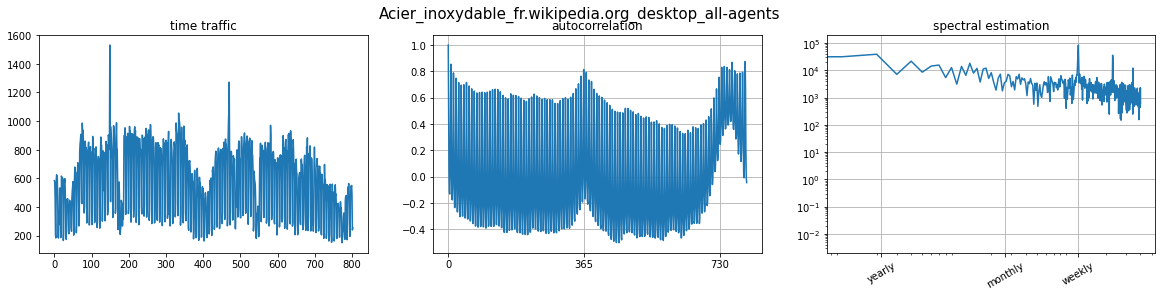

In [13]:
# remarkable pages
rem_pages = [
    'Acier_inoxydable_fr.wikipedia.org_desktop_all-agents',
]
page = rem_pages[0]
traffic_t =  df_examples.loc[page].values
f,vax = plt.subplots(1,3, figsize=(20,4))
fax = vax.flat


ax=next(fax)
ax.plot(traffic_t)
ax.set_title("time traffic")


ax=next(fax)
ax.plot(estimated_autocorrelation(traffic_t))
ax.set_xticks([0,365,2*365])
ax.set_title("autocorrelation")
ax.grid()

ax=next(fax)
plot_spectrest(traffic_t, ax)
ax.set_title("spectral estimation")




plt.suptitle(page, fontsize=15)
plt.show()

[linear model](#linear-model)  
[RNN](#RNN)  


## Models

[repeat last value](#repeat-last-value)  
[linear model](#linear-model)

###### repeat last value

def repeat_lv(X):
    return np.tile(X[:,-1].reshape(-1,1), reps=(1,output_len))

smape_np(repeat_lv(x_train), y_train), smape_np(repeat_lv(x_valid), y_valid), smape_np(repeat_lv(x_test), y_test)


repeat_lv(x_train)

### linear model

In [ ]:
tf.keras.backend.clear_session()
tb_cb = create_tb_cb("linear")

class preprocessing(tf.keras.layers.Layer):
    def call(self, inputs):
        return inputs[:,-150:]

inputs = tf.keras.layers.Input(shape=(741,))
agent = tf.keras.layers.Input(shape=())
access = tf.keras.layers.Input(shape=())
project = tf.keras.layers.Input(shape=())
x = preprocessing()(inputs)
outputs = tf.keras.layers.Dense(units=output_len)(x)

model_linear = tf.keras.Model(inputs=[agent, access, project, inputs], outputs=[outputs])

model_linear.summary()

In [ ]:
model_linear.compile(loss=smape_reg, optimizer=tf.optimizers.Adam(learning_rate=1e-4), 
                     metrics=[smape,"mae"],)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.05)
lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
#ds1.cache()
model_linear.fit(ds, epochs=100, callbacks=[tb_cb, lr_cb], validation_data=val_ds)

In [ ]:
weights = model_linear.get_layer("dense").get_weights()[0]

f,ax = plt.subplots()
ax.plot(np.abs(weights[:,0]))
ax.grid()

In [ ]:
def linear_estimator(x):
    """
    Args:
        x np.array, len=741
    """
    fake_feature = np.array([b""], dtype=object)
    return model_linear.predict((fake_feature, fake_feature, fake_feature,[x.reshape(1,-1)]))[0]

#linear_estimator(df_examples.loc[page].values[:-output_len])

In [ ]:
f, ax = plt.subplots()
plot_check_result(df_examples.loc[page].values, linear_estimator, ax)
ax.set_title(page)
plt.show()

### RNN

In [28]:
#!rm -Rf logs/*

In [36]:
Limit_train=5000
Nneurons = 20
Nlayers = 2
MaxTs = 150

simn = 'Ltr'+str(Limit_train)+'-Ts'+str(MaxTs)+'-Nn'+str(Nneurons)+'-Nl'+str(Nlayers)

tf.keras.backend.clear_session()
tb_cb = create_tb_cb(simn)

class preprocessing_rnn(tf.keras.layers.Layer):
    def call(self, inputs):
        ret = inputs
        return ret[:,-MaxTs:,np.newaxis]

inputs = tf.keras.layers.Input(shape=(741,))
agent = tf.keras.layers.Input(shape=())
access = tf.keras.layers.Input(shape=())
project = tf.keras.layers.Input(shape=())
x = preprocessing_rnn()(inputs)
for ii in range(Nlayers-1):
    x = tf.keras.layers.GRU(Nneurons, return_sequences=True)(x)
x = tf.keras.layers.GRU(Nneurons)(x)
outputs= tf.keras.layers.Dense(output_len)(x)

model_rnn = tf.keras.Model(inputs=[agent, access, project, inputs], outputs=[outputs])

model_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 741)]        0                                            
__________________________________________________________________________________________________
preprocessing_rnn (preprocessin (None, 150, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 150, 20)      1380        preprocessing_rnn[0][0]          
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 20)           2520        gru[0][0]                        
______________________________________________________________________________________________

In [37]:
model_rnn.compile(loss=smape_reg, optimizer=tf.optimizers.Adam(learning_rate=1e-3),metrics=[smape, "mae"])

In [38]:
model_rnn.fit(ds, epochs=100, callbacks=[tb_cb], validation_data=val_ds)

Epoch 1/100
313/313 [==============================] - 9s 20ms/step - loss: 17.0948 - smape: 81.3179 - mae: 0.0486 - val_loss: 10.1228 - val_smape: 60.9636 - val_mae: 0.0284
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 10.5347 - smape: 55.5404 - mae: 0.0305 - val_loss: 9.9978 - val_smape: 59.5408 - val_mae: 0.0280
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 10.4380 - smape: 55.1270 - mae: 0.0302 - val_loss: 9.9034 - val_smape: 58.6711 - val_mae: 0.0277
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 10.3711 - smape: 55.2501 - mae: 0.0299 - val_loss: 9.7975 - val_smape: 55.9775 - val_mae: 0.0275
Epoch 5/100
313/313 [==============================] - 5s 16ms/step - loss: 10.3043 - smape: 55.0445 - mae: 0.0298 - val_loss: 9.7150 - val_smape: 55.2850 - val_mae: 0.0272
Epoch 6/100
313/313 [==============================] - 5s 16ms/step - loss: 10.2419 - smape: 54.9591 - mae: 0.0296 - val_loss: 9.6391 

KeyboardInterrupt: ignored

In [ ]:
def rnn_estimator(x):
    """
    Args:
        x np.array, len=741
    """
    fake_feature = np.array([b""], dtype=object)
    fnorm = 1.0
    if normalize_ds:
        fnorm = np.max(x)
    return model_rnn.predict((fake_feature, fake_feature, fake_feature,[x.reshape(1,-1)/fnorm]))[0] * fnorm


In [ ]:
%matplotlib notebook
f, ax = plt.subplots()
plot_check_result(df_examples.loc[page].values, rnn_estimator, ax)
ax.set_title(page)
plt.show()

### ouput

In [ ]:
key = pd.read_csv("key_2.csv.zip").set_index("Page")

In [ ]:
key["Visits"] = None
key.head()

In [ ]:
def output_form(_df, _estimator=None):
    """ return a serie indexed by Page """
    out_date = pd.date_range(start="2017-09-13", end="2017-11-13", freq="1D").strftime("%Y-%m-%d").to_list()
    num_hist = _df.drop(columns="Page").fillna(0).values
    num_pred = _estimator(num_hist)
    ret = pd.DataFrame(num_pred, columns=out_date, index=_df["Page"]).stack().rename("Visits")
    ret.index = [ii[0]+"_"+ii[1] for ii in ret.index]
    return ret

chunk = pd.read_csv("train_2.csv.zip", nrows=10000)
Visits_pred = output_form(chunk, linear_estimator)

In [ ]:
df_chunk = pd.read_csv("train_2.csv.zip", chunksize=10000)

for ii, chunk in enumerate(df_chunk):
    print("Prediction {}".format(ii))
    predictions = output_form(chunk, rnn_predict).astype(int)
    key.loc[predictions.index, "Visits"] = predictions.astype(int)

In [ ]:
key.to_csv("subm_gru.csv", encoding='utf-8', index=False)